In [2]:
import sys
import os
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.utils import preprocessing as pp

In [3]:
def load_data(data_path, dt = 1e-1, t_washout_len = 4, t_train_len = 256, t_val_len = 64, grid_upsample = 4, train_var = "gal"):
   # load rijke system from data
   data_dict = pp.read_h5(data_path)

   t_transient_len = data_dict["t_transient"]

   data_dt = data_dict["t"][1]-data_dict["t"][0]
   upsample = int(np.round(dt/data_dt))

   #pres = data_dict["P"][:,1:-1:grid_upsample]
   #pres_single = data_dict["P"][:,5][:,None]
   #vel = data_dict["U"][:,1:-1:grid_upsample]
   #pres_vel = np.hstack((data_dict["P"][:,1:-1],data_dict["U"]))

   eta = data_dict["y"][:, 0 : data_dict["N_g"]]  # Galerkin variables velocity
   mu = data_dict["y"][:, data_dict["N_g"] : 2 * data_dict["N_g"]]  # Galerkin variables pressure
   gal = data_dict["y"][:, 0 : 2 * data_dict["N_g"]]
   
   if train_var == "gal":
    U_sim = gal
   #elif train_var == "pres":
   # U_sim =  pres
   #elif train_var == "vel":
   # U_sim = vel
   #elif train_var == "pres_vel":
   # U_sim = pres_vel

   t_sim = data_dict["t"]

   # upsample
   U = U_sim[::upsample,:]
   t = t_sim[::upsample]

   # cut the transient    
   N_transient = int(np.round(t_transient_len/dt))
   U = U[N_transient:,:]
   t = t[N_transient:]-t[N_transient]

   # separate into washout, train, val
   N_washout = int(np.round(t_washout_len/dt))
   N_train = int(np.round(t_train_len/dt))
   N_val = int(np.round(t_val_len/dt))

   U_washout_train = U[0:N_washout,:]
   
   U_train = U[N_washout:N_washout+N_train-1,:]
   Y_train = U[N_washout+1:N_washout+N_train,:]
   t_train = t[N_washout+1:N_washout+N_train]

   U_washout_val = U[N_washout+N_train:2*N_washout+N_train,:]
   U_val = U[2*N_washout+N_train:2*N_washout+N_train+N_val-1,:]
   Y_val = U[2*N_washout+N_train+1:2*N_washout+N_train+N_val,:]
   t_val = t[2*N_washout+N_train+1:2*N_washout+N_train+N_val]

   U_data = U[:N_washout+N_train]

   return U_washout_train, U_train, Y_train, t_train, U_washout_val, U_val, Y_val, t_val, U_data

In [4]:
hyp_results, hyp_file = pp.unpickle_file("results/validation_run.pickle")

In [6]:
hyp_results

{'data_config': {'dt': 0.1,
  't_washout_len': 8,
  't_train_len': 256,
  'grid_upsample': 4,
  'train_var': 'gal'},
 'p_train_val_list': array([[2.5 , 0.17],
        [2.5 , 0.18],
        [2.5 , 0.19],
        [2.5 , 0.25],
        [2.5 , 0.16],
        [2.5 , 0.21]]),
 'train_idx_list': array([0, 1, 2, 3]),
 'val_idx_list': array([0, 1, 2, 3, 4, 5]),
 'hyp_param_names': ['spectral_radius',
  'input_scaling',
  'parameter_normalization_mean',
  'parameter_normalization_var'],
 'hyp_param_scales': ['uniform', 'log10', 'uniform', 'log10'],
 'hyp_grid_range': [[0.1, 1.0], [-1.0, 1.0], [-0.4, 0.4], [-1.0, 1.0]],
 'ESN_dict': {'reservoir_size': 1000,
  'dimension': 20,
  'parameter_dimension': 1,
  'reservoir_connectivity': 3,
  'input_normalization': (array([-4.91792228e-01, -3.96755196e-01, -2.65032309e-01, -1.22891256e-01,
          -2.04909424e-17,  8.19719953e-02,  1.13676642e-01,  9.94575566e-02,
           5.46377656e-02,  2.04913316e-17,  3.53217803e-03,  9.59067704e-04,
          

In [32]:
#p_list = [0.6,0.7,0.8,0.9,1.0,1.2]
#p_name_list = ["0_6","0_7","0_8","0_9","1","1_2"]
#p_list = [5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5]
#p_name_list = ["5_8","5_9","6","6_1","6_2","6_3","6_4","6_5"]
#p_list = [1.2,1.3,1.5,1.7,2.0,2.3,2.5,2.7,3.0,3.3,3.5,3.7,4.0,4.3,4.5,4.7,5.0,5.3,5.5,5.7]
#p_name_list = ["1_2","1_3","1_5","1_7","2","2_3","2_5","2_7","3","3_3","3_5","3_7","4","4_3","4_5","4_7","5","5_3","5_5","5_7"]
#p_list = [2.0,2.3,2.5,2.7,3.0]
#p_name_list = ["2","2_3","2_5","2_7","3"]
#p_list = np.arange(0.05,0.55,0.05)
p_list = [0.17,0.21,0.19,0.25,0.16,0.18]
len_p_list = len(p_list)
U_washout_train = [None]*len_p_list
U_train = [None]*len_p_list
U_data = [None]*len_p_list
Y_train = [None]*len_p_list
t_train = [None]*len_p_list
U_washout_val = [None]*len_p_list
U_val = [None]*len_p_list
U_val = [None]*len_p_list
Y_val = [None]*len_p_list
t_val = [None]*len_p_list

P_washout_train = [None]*len_p_list
P_train = [None]*len_p_list
P_washout_val = [None]*len_p_list
P_val = [None]*len_p_list
P_mean = np.array(np.mean(p_list))

for p_idx in range(len_p_list):
    tau_name = f'{p_list[p_idx]:.2f}'
    tau_name = tau_name.replace(".","_")
    train_str = f"data/rijke_kings_poly_beta_2_50_tau_{tau_name}.h5"
    #train_str = f"data/rijke_kings_poly_beta_{p_name_list[p_idx]}_tau_0_2.h5"
    U_washout_train[p_idx], U_train[p_idx], Y_train[p_idx], t_train[p_idx], U_washout_val[p_idx], U_val[p_idx], Y_val[p_idx], t_val[p_idx], U_data[p_idx] = load_data(train_str)
    P_washout_train[p_idx] = p_list[p_idx]*np.ones((len(U_washout_train[p_idx]),1))
    P_train[p_idx] = p_list[p_idx]*np.ones((len(U_train[p_idx]),1))
    P_washout_val[p_idx] = p_list[p_idx]*np.ones((len(U_washout_val[p_idx]),1))
    P_val[p_idx] = p_list[p_idx]*np.ones((len(U_val[p_idx]),1))
U_data = np.vstack(U_data)

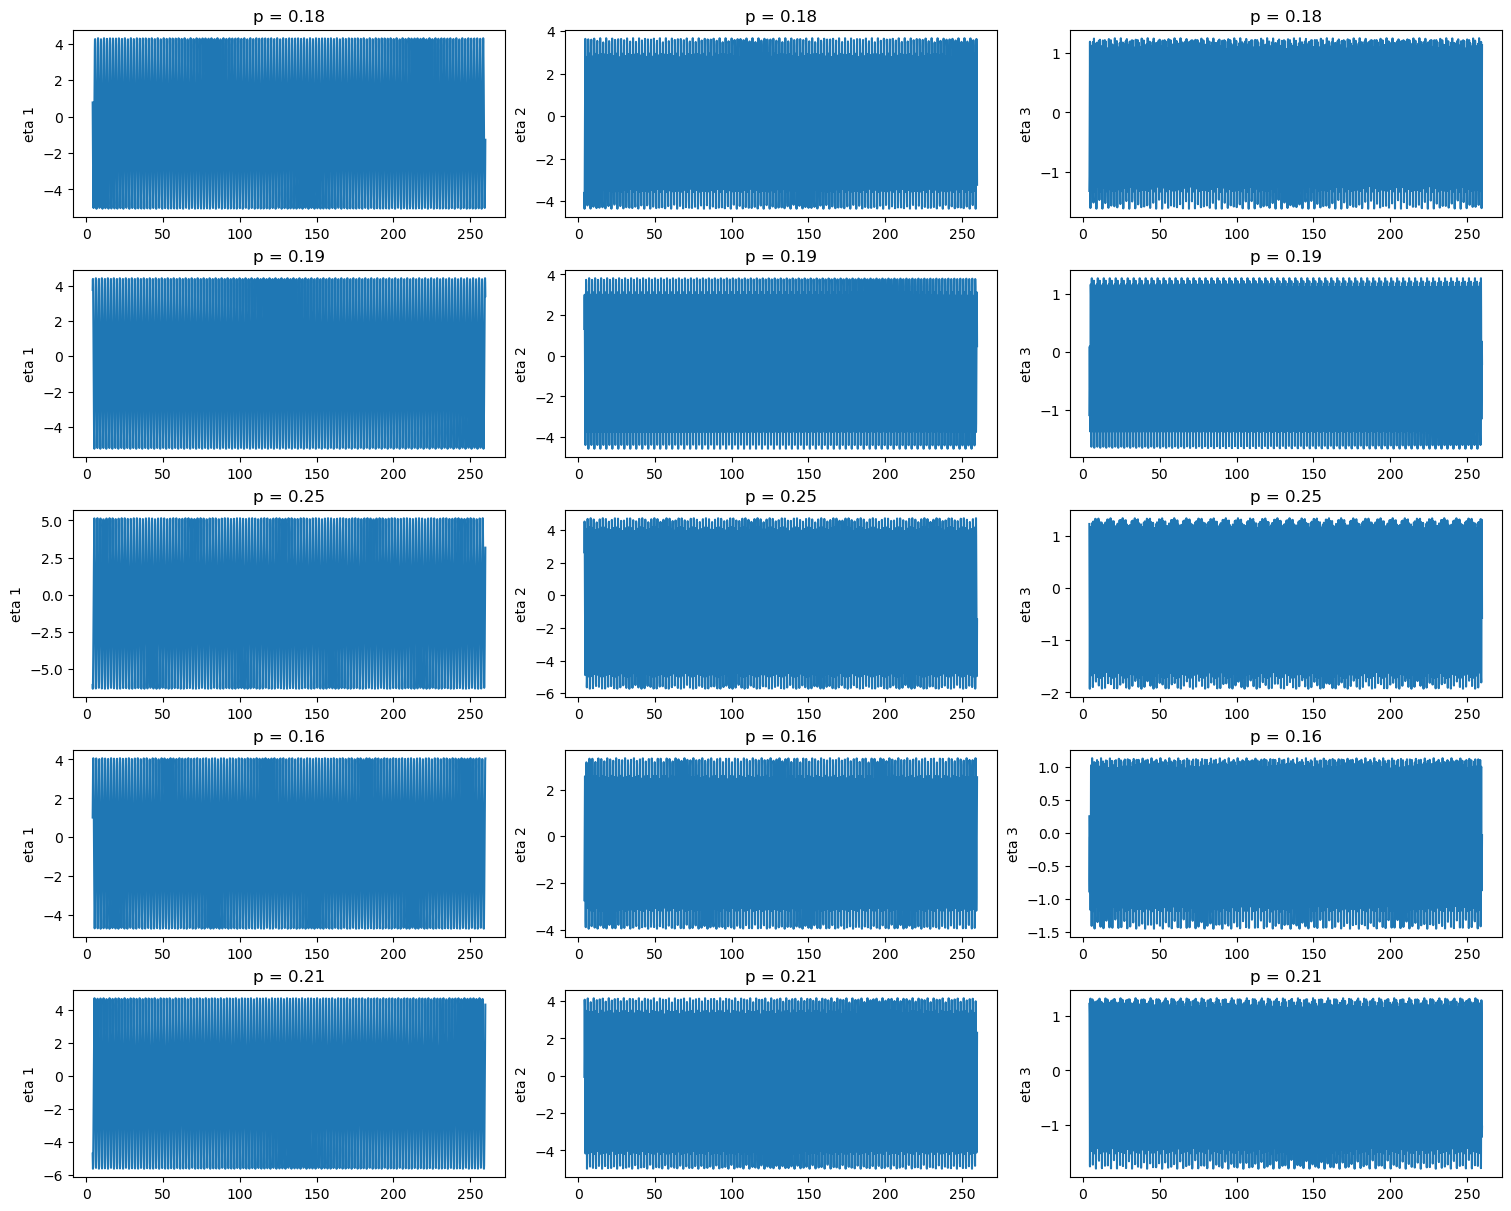

In [10]:
plt.figure(figsize = (15,12), constrained_layout = True)

for p_idx in range(len_p_list):
    for j in range(3):
        plt.subplot(len_p_list,3,3*p_idx+j+1)
        plt.plot(t_train[p_idx][:],U_train[p_idx][:,j])
        plt.title(f"p = {p_list[p_idx]}")
        plt.ylabel(f"eta {j+1}")
        #plt.xlim([600,620])
        #plt.xlabel("t")

In [33]:
U_mean = U_data.mean(axis = 0)
U_std = U_data.std(axis = 0)
m = U_data.min(axis=0)
M = U_data.max(axis=0)
U_norm = M-m 
scale = (U_mean, U_std)

input_bias = np.array([np.mean(np.abs((U_data-scale[0])/scale[1]))])

dim = U_train[0].shape[1]

In [16]:
len_p_list

6

In [34]:
#train_idx_list = [1,2,3,5,6,7,9,11,12,13,15,17,18] # indices of which parameter datasets to use for training
#val_idx_list = [0,4,8,10,14,16,19] # indices of which parameter datasets to use for validation

#train_idx_list = [1,3,5,7,9] # indices of which parameter datasets to use for trainin
#val_idx_list = [0,2,4,6,8] # indices of which parameter datasets to use for validation

train_idx_list = [0,1,2,3] # indices of which parameter datasets to use for training
val_idx_list = [4,5] # indices of which parameter datasets to use for validation

In [ ]:
from adjoint_esn.validation import validate

#range for hyperparameters (spectral radius and input scaling)
spec_in     = 0.1   
spec_end    = 1.0   
in_scal_in  = np.log10(0.1)
in_scal_end = np.log10(10.0)
leak_in     = 0.1    
leak_end    = 1.0  
param_norm_mean_in = 0.0
param_norm_mean_end = 1.0
param_norm_var_in = np.log10(0.01)
param_norm_var_end = np.log10(2.0)
grid_range = [[spec_in, spec_end],[in_scal_in, in_scal_end],[param_norm_mean_in, param_norm_mean_end],[param_norm_var_in, param_norm_var_end]]
# In case we want to start from a grid_search, 
# the first n_grid_x*n_grid_y points are from grid search
param_names = ['spectral_radius','input_scaling','parameter_normalization_mean','parameter_normalization_var']
param_scales = ['uniform', 'log10','uniform','log10']
n_grid = [4, 4, 4, 4]
N_washout = 40
N_val = 640
ESN_dict = {'reservoir_size': 2000, 
            'dimension' : dim, 
            'parameter_dimension' : 1,
            'reservoir_connectivity' : 3,
            'input_normalization': scale, 
            'input_bias' : input_bias}
min_dict = validate(n_grid, grid_range, param_names, param_scales, 
    n_bo = 4, n_initial = 0, n_ensemble = 3, ESN_dict = ESN_dict, U_washout = U_washout_train, 
    U = U_train, Y = Y_train, P_washout = P_washout_train, P = P_train,
    n_folds = 1, N_init_steps = N_washout, N_fwd_steps = 80, N_washout_steps = N_washout, N_val_steps = N_val, 
    train_idx_list = train_idx_list, val_idx_list = val_idx_list, noise_std = 0)

In [ ]:
# hyperparameters for N_reservoir = 1000, connectivity = 3
# training [2.0,2.5,3.0]
# validation [2.0,2.3,2.5,2.7,3.0]
min_dict

In [ ]:
my_ESN = ESN(reservoir_size = 2000, dimension = dim, parameter_dimension = 1, reservoir_connectivity = 3, 
                input_scaling = 3.44979129, spectral_radius = 0.2,
                leak_factor = 1.0, input_bias = input_bias, input_normalization = scale, parameter_normalization=[np.array([6.84469073]),np.array(10.0)],
                input_seeds=[0,1,2],reservoir_seeds=[3,4],)

In [18]:
hyp_results["min_dict"]

{'params': array([[0.9787647 , 1.7425686 , 0.39999561, 0.38181125],
        [1.        , 1.92899097, 0.12481763, 0.34119707],
        [0.4       , 2.15443469, 0.13333333, 0.1       ]]),
 'tikh': [1, 0.1, 0.01],
 'f': array([-3.70823931, -3.05672582, -3.33745256]),
 'input_seeds': [[0, 1, 2], [4, 5, 6], [8, 9, 10]],
 'reservoir_seeds': [[3, 4], [7, 8], [11, 12]]}

In [35]:
my_ESN = ESN(reservoir_size = 1000, dimension = dim, parameter_dimension = 1, reservoir_connectivity = 3, 
                input_scaling = 1.7425686, spectral_radius = 0.9787647,
                leak_factor = 1.0, input_bias = input_bias, input_normalization = scale, parameter_normalization=[np.array([0.39999561]),np.array(0.38181125)],
                input_seeds=[0,1,2],reservoir_seeds=[3,4],)

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [ ]:
my_ESN = ESN(reservoir_size = 1000, dimension = dim, parameter_dimension = 1, reservoir_connectivity = 3, 
                input_scaling = 0.46415888, spectral_radius = 0.1,
                leak_factor = 1.0, input_bias = input_bias, input_normalization = scale, parameter_normalization=[np.array([1.0]),np.array([0.34199519])],
                input_seeds=[4,5,6],reservoir_seeds=[7,8],)

In [36]:
noise_std = 0
U_washout_train_noisy = [None]*len_p_list
U_train_noisy = [None]*len_p_list
for p_idx in range(len_p_list):    
    data_std = np.std(U_train[p_idx], axis = 0)
    rnd  = np.random.RandomState(70+p_idx)
    mean = np.zeros(U_train[p_idx].shape[1])
    std = (noise_std/100)*data_std
    U_washout_train_noisy[p_idx] = U_washout_train[p_idx] + rnd.normal(mean,std,U_washout_train[p_idx].shape)
    U_train_noisy[p_idx] = U_train[p_idx] + rnd.normal(mean,std,U_train[p_idx].shape)

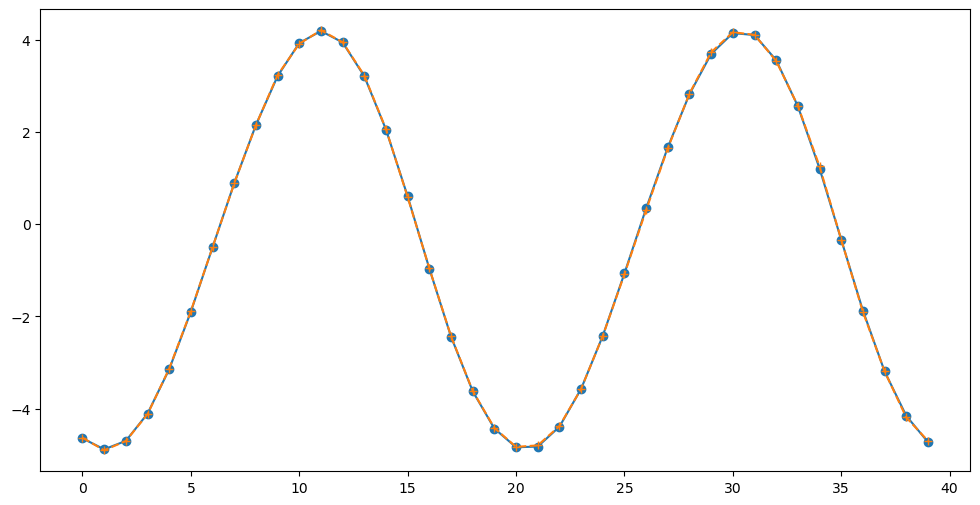

In [15]:
plt.figure(figsize=(12,6))
plt.plot(U_washout_train[0][:,0],'-o')
plt.plot(U_washout_train_noisy[0][:,0],'--+')

In [37]:
my_ESN.train(U_washout_train_noisy, U_train_noisy, Y_train, tikhonov = 1, P_washout=P_washout_train, P_train=P_train,train_idx_list = train_idx_list,)

In [12]:
def L2_error(y, y_pred):
    return np.linalg.norm(y-y_pred, 'fro')

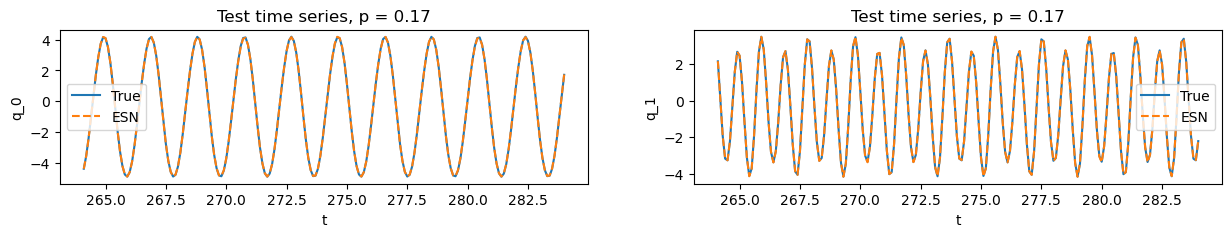

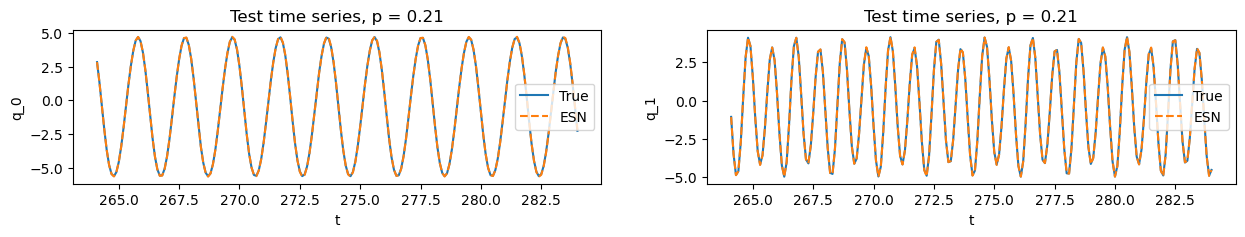

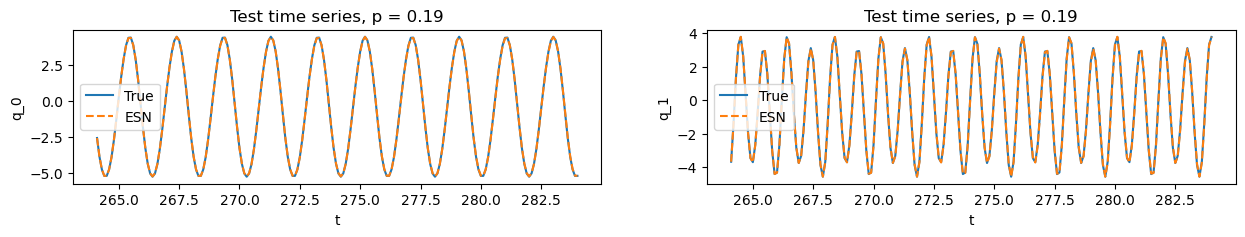

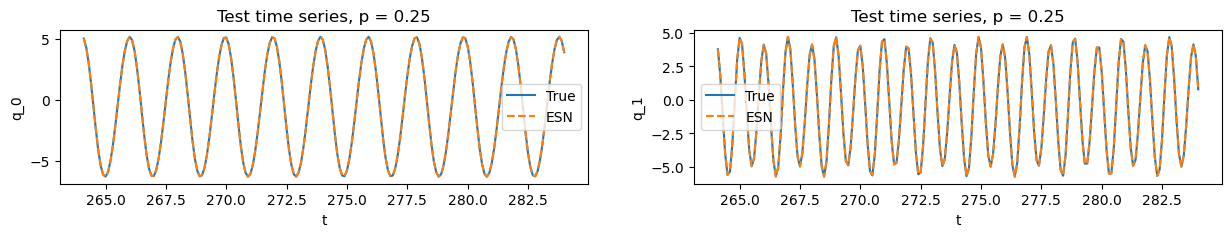

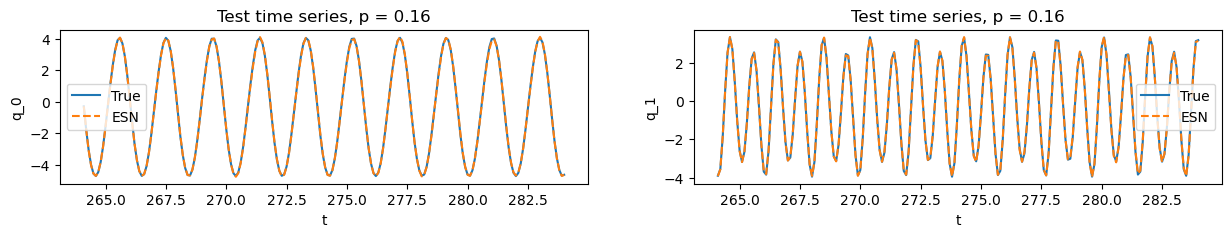

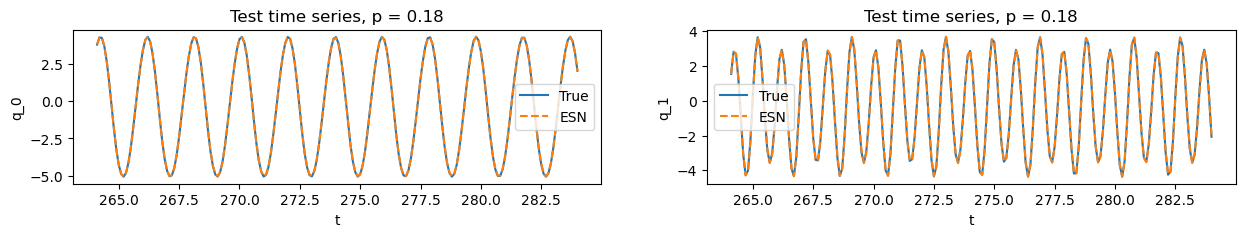

Train error:  7.574610208881743
Validation error:  1.3831225310513704
Train error:  13.811099097151951
Validation error:  2.0177290914542967
Train error:  7.507838846091138
Validation error:  4.283601352297629
Train error:  9.375192846622058
Validation error:  1.380024773365163
Train error:  63.554911776804865
Validation error:  6.593484612133234
Train error:  21.309151691314252
Validation error:  3.564662116303855


In [38]:
plt_idx = [0,1]
Y_pred_train = [None]*len_p_list
for p_idx in range(len_p_list):
    _, Y_pred_train_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_train[p_idx], N_t = len(U_train[p_idx]), P_washout=P_washout_train[p_idx], P = P_train[p_idx])
    Y_pred_train[p_idx] = Y_pred_train_[1:,:]
    #for j in plt_idx:
    #    plt.figure(figsize=(8,2))
    #    plt.plot(t_train[p_idx], Y_train[p_idx][:,j])
    #    plt.plot(t_train[p_idx], Y_pred_train[p_idx][:,j],'--')
    #    plt.title(f"Training time series, p = {p_list[p_idx]}")
    #    plt.xlabel("t")
    #    plt.ylabel(f"q_{j}")
    #    plt.legend(["True", "ESN"])

Y_pred_val = [None]*len_p_list
#len(U_val[p_idx])
for p_idx in range(len_p_list):
    _, Y_pred_val_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_val[p_idx], N_t = len(U_val[p_idx]), P_washout=P_washout_val[p_idx], P = P_val[p_idx])
    Y_pred_val[p_idx] = Y_pred_val_[1:,:]
    plt.figure(figsize=(15,2))
    for j in plt_idx:
        plt.subplot(1,2,j+1)
        #plt.plot(t_val, Y_val[:,j]-Y_pred_val[:,j])
        plt.plot(t_val[p_idx][:200], Y_val[p_idx][:200,j])
        plt.plot(t_val[p_idx][:200],Y_pred_val[p_idx][:200,j],'--')
        plt.title(f"Test time series, p = {p_list[p_idx]}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j}")
        plt.legend(["True", "ESN"])
plt.show()

# calculate error
for p_idx in range(len_p_list):
    train_error = L2_error(Y_train[p_idx], Y_pred_train[p_idx])
    val_error = L2_error(Y_val[p_idx], Y_pred_val[p_idx])
    print("Train error: ", train_error)
    print("Validation error: ", val_error)

Train error:  252.487793994514
Validation error:  37.7879217503933
Train error:  61.650905169605565
Validation error:  6.877497327610487


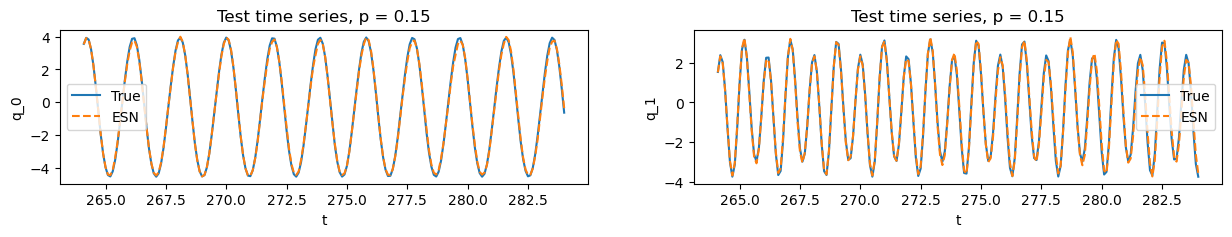

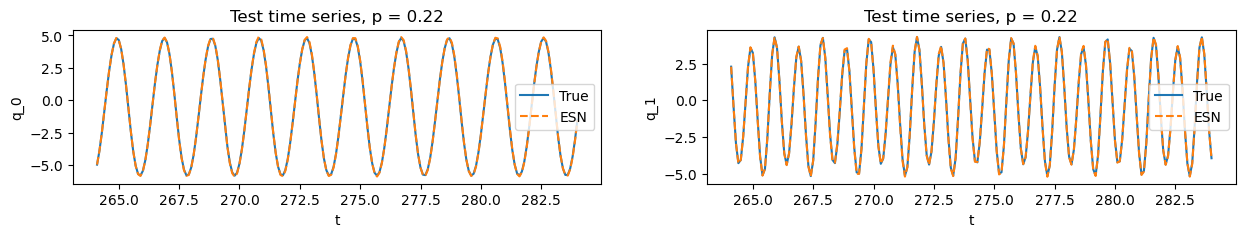

In [39]:
plt_idx = [0,1]
pp_test_list = [0.15,0.22]
pp_test_name_list = ["0_15","0_22"]
#pp_test_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1.0]
#pp_test_name_list = ["0_6","0_6","0_6","0_6","0_6","0_6","0_6","0_6","0_6"]
#pp_test_list = [5.5,5.7,6.2,6.5,7]
#pp_test_name_list = ["5_5","5_7","6_2","6_5","7"]
#pp_test_list = [5.82,5.83,5.84,5.93]
#pp_test_name_list = ["5_82","5_83","5_84","5_93"]
for test_idx, pp_test in enumerate(pp_test_list): 
    test_str = f"data/rijke_kings_poly_beta_2_50_tau_{pp_test_name_list[test_idx]}.h5"
    U_washout_test, U_test, Y_test, t_test, U_washout_testval, U_testval, Y_testval, t_testval, U_data_test = load_data(test_str)
    P_test = pp_test*np.ones((len(U_test),1))
    P_testval = pp_test*np.ones((len(U_testval),1))
    P_washout_test = pp_test*np.ones((len(U_washout_test),1))
    P_washout_testval = pp_test*np.ones((len(U_washout_testval),1))
    X_pred_test, Y_pred_test = my_ESN.closed_loop_with_washout(U_washout = U_washout_test, N_t = len(U_test), P_washout=P_washout_test, P = P_test)
    Y_pred_test = Y_pred_test[1:,:]

    X_pred_testval, Y_pred_testval = my_ESN.closed_loop_with_washout(U_washout = U_washout_testval, N_t = len(U_testval), P_washout=P_washout_testval, P = P_testval)
    Y_pred_testval = Y_pred_testval[1:,:]
    plt.figure(figsize=(15,2))
    for j in plt_idx:
        #plt.figure(figsize=(8,2))
        plt.subplot(1,2,j+1)
        #plt.plot(t_test, Y_test[:,j])
        #plt.plot(t_test, Y_pred_test[:,j])
        plt.plot(t_testval[:200], Y_testval[:200,j])
        plt.plot(t_testval[:200], Y_pred_testval[:200,j],'--')
        plt.title(f"Test time series, p = {pp_test}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j}")
        plt.legend(["True", "ESN"])

    test_error = L2_error(Y_test, Y_pred_test)
    testval_error = L2_error(Y_testval, Y_pred_testval)
    print("Train error: ", test_error)
    print("Validation error: ", testval_error)

In [40]:
from adjoint_esn.rijke_galerkin.solver import Rijke
from scipy.integrate import odeint
import copy 

data_dt = 1e-3
dt = 1e-1
upsample = int(np.round(dt/data_dt))

def run_sim(data_path = None, my_rijke = None, t_sim_len = None, t_washout_len = 4):
    # Initial conditions
    rand = np.random.RandomState(seed=1)
    y0 = np.zeros(my_rijke.N_dim+1)
    #y0[0 : my_rijke.N_dim] = rand.rand(my_rijke.N_dim)
    y0[0] = 1 #rand.rand(my_rijke.N_dim)
    #y0[my_rijke.N_g] = 1

    # Temporal grid
    t_sim = np.arange(0, t_sim_len+data_dt, data_dt)
#
    # Solve ODE using odeint
    y_sim = odeint(my_rijke.ode, y0, t_sim, tfirst=True)
    #data_dict = pp.read_h5(data_path)
    #y_sim = data_dict["y"]
    #t_sim = data_dict["t"]
    U_sim = y_sim[:, 0 : 2 * my_rijke.N_g]

    # cut the transient
    t_transient_len = 200
    t_washout_len = 4
    N_transient = int(np.round(t_transient_len/data_dt))
    N_washout_data = int(np.round(t_washout_len/data_dt))
    y_sim = y_sim[N_transient:,:]
    U_sim = U_sim[N_transient:,:]
    t_sim = t_sim[N_transient:]-t_sim[N_transient]

    y_bar = y_sim[N_washout_data:,:]
    U_bar = U_sim[N_washout_data:,:]
    t_bar = t_sim[N_washout_data:]-t_sim[N_washout_data]

    # upsample
    U = U_sim[::upsample,:]
    t = t_sim[::upsample]

    # separate into washout, train, val
    N_washout = int(np.round(t_washout_len/dt))

    U_washout = U[0:N_washout,:]
    U_grad = U[N_washout:,:]
    t_grad = t[N_washout:]-t[N_washout]

    P_washout = my_rijke.tau*np.ones((len(U_washout),1))
    P_grad = my_rijke.tau*np.ones((len(U_grad),1))
    return y_bar, U_bar, t_bar, U_washout, U_grad, t_grad, P_washout, P_grad

def run_true_grad(my_rijke, t_bar, y_bar):
    # direct problem
    #dir0 = np.zeros(2*my_rijke.N_dim+2)
    #dir = odeint(my_rijke.direct_ode,dir0,t_bar,args=(t_bar,1/data_dt,y_bar),tfirst= True)
    #dJ_dp_dir = 1/t_bar[-1]*dir[-1,-2]
    dJ_dp_dir = 0
    
    # adjoint problem
    #adjT = np.zeros(my_rijke.N_dim+2)
    #adj = odeint(my_rijke.adjoint_ode,adjT,np.flip(t_bar),args =(t_bar,1/data_dt,y_bar),tfirst= True)
    #dJ_dp_adj  = 1/t_bar[-1]*adj[-1,-2]
    #plt.figure()
    #plt.plot(t_bar[1:],1/t_bar[1:]*adj[1:,-2])
    #plt.xlabel("t")
    #plt.title("dJ/dbeta")
    #plt.figure()
    #plt.plot(t_bar[1:],1/t_bar[1:]*adj[1:,-1])
    #plt.title("dJ/dtau")
    dJ_dp_adj = 0
    
    # Calculate numerically
    # Find perturbed solutions (in beta)
    h = 1e-5 # perturbation on the parameter
    J_beta = 1/4*np.mean(np.sum(y_bar[::upsample,0:2*my_rijke.N_g]**2, axis = 1))
    
    # left solution with beta = beta-h
    my_rijke_beta_left = Rijke(N_g=10,N_c=10,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=0.2,tau=my_rijke.tau-h,heat_law="kings_poly",damping="modal")
    #my_rijke_beta_left = copy.copy(my_rijke)
    #my_rijke_beta_left.beta -= h
    y_bar_beta_left = odeint(my_rijke_beta_left.ode,y_bar[0,:],t_bar,tfirst = True)
    eta_bar_beta_left = y_bar_beta_left[:,0:my_rijke_beta_left.N_g] 
    mu_bar_beta_left = y_bar_beta_left[:,my_rijke_beta_left.N_g:2*my_rijke_beta_left.N_g]
    #J_beta_left = 1/t_bar[-1]*(y_bar_beta_left[-1,-1]-y_bar_beta_left[0,-1]) # time average until t
    J_beta_left = 1/4*np.mean(np.sum(y_bar_beta_left[::upsample,0:2*my_rijke_beta_left.N_g]**2, axis = 1))
        
    # right solution with beta = beta+h
    my_rijke_beta_right = Rijke(N_g=10,N_c=10,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=0.2,tau=my_rijke.tau+h,heat_law="kings_poly",damping="modal")
    #my_rijke_beta_right = copy.copy(my_rijke)
    #my_rijke_beta_right.beta += h
    y_bar_beta_right = odeint(my_rijke_beta_right.ode,y_bar[0,:],t_bar,tfirst = True)
    eta_bar_beta_right = y_bar_beta_right[:,0:my_rijke_beta_right.N_g] 
    mu_bar_beta_right = y_bar_beta_right[:,my_rijke_beta_right.N_g:2*my_rijke_beta_right.N_g]
    #J_beta_right = 1/t_bar[-1]*(y_bar_beta_right[-1,-1]-y_bar_beta_right[0,-1]) # time average until t
    J_beta_right = 1/4*np.mean(np.sum(y_bar_beta_right[::upsample,0:2*my_rijke_beta_right.N_g]**2, axis = 1))
    dJ_dp_num = (J_beta_right-J_beta_left)/(2*h)
    dJ_dp_num = (J_beta_right-J_beta)/(h) 
    #dJ_dp_num = 0
    print("J = ", J_beta)
    print("J left = ",J_beta_left)
    print("J right = ",J_beta_right)

    print("dJ/dp direct = ", dJ_dp_dir)
    print("dJ/dp adjoint = ", dJ_dp_adj)
    print("dJ/dp numerical = ", dJ_dp_num)

    #plt.figure(figsize = (10,3))
    #plt.plot(t_bar,y_bar[:,0])
    #plt.figure(figsize = (10,3))
    #plt.plot(t_bar,y_bar_beta_left[:,0])
    #plt.figure(figsize = (10,3))
    #plt.plot(t_bar,y_bar_beta_right[:,0])

    return dJ_dp_dir,dJ_dp_adj,dJ_dp_num

def run_esn_grad(my_ESN, N, X_pred_grad, Y_pred_grad, P_grad):
    # OBJECTIVE SQUARED L2 OF OUTPUT STATES (ACOUSTIC ENERGY)
    # calculate gradient for a timeseries, direct method
    # time averaged objective
    #q = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
    #q_prev = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
    dJ_dp_dir = np.zeros(my_ESN.N_param_dim)
    #for i in np.arange(1,N):
    #    q = my_ESN.drdp(X_pred_grad[i,:]).toarray()+np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray(),q_prev)
    #    q_prev = q 
    #    X_pred_aug = np.hstack((X_pred_grad[i,:], my_ESN.b_out))
    #    dJ_dr = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    #    #dJ_dr2 = (1/N)*2*np.einsum("r, rb, bn -> n", X_pred_aug,my_ESN.W_out,my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    #    dJ_dp_dir += np.dot(dJ_dr,q)

    # calculate gradient for a timeseries, adjoint method
    # time averaged objective
    #X_pred_aug = np.hstack((X_pred_grad[N-1,:], my_ESN.b_out))
    #v_prev = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T).T
    dJ_dp_adj = np.zeros(my_ESN.N_param_dim)
    #for i in np.arange(N-1,0,-1):
    #    dJ_dp_adj += np.dot(my_ESN.drdp(X_pred_grad[i,:]).toarray().T,v_prev)
    #    X_pred_aug = np.hstack((X_pred_grad[i-1,:], my_ESN.b_out))
    #    dJ_dr = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T).T
    #    v = np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray().T,v_prev)+dJ_dr 
    #    v_prev = v

    # calculate gradient for a timeseries, numerical method
    # time averaged objective 
    h = 1e-5
    J = 1/4*np.mean(np.sum(Y_pred_grad**2, axis = 1))
    
    dJ_dp_num = np.zeros((my_ESN.N_param_dim))
    for i in range(my_ESN.N_param_dim):
        P_left = P_grad.copy()
        P_left[:,i] -= h
        P_right = P_grad.copy()
        P_right[:,i] += h
        X_left, Y_left = my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_left)
        X_right, Y_right =  my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_right)
        J_left = 1/4*np.mean(np.sum(Y_left**2, axis = 1))
        J_right = 1/4*np.mean(np.sum(Y_right**2, axis = 1))
        dJ_dp_num[i] = (J_right-J_left)/(2*h)

    print("J ESN = ", J)
    print("J left ESN = ",J_left)
    print("J right ESN = ",J_right)

    print("dJ/dp direct ESN = ", dJ_dp_dir)
    print("dJ/dp adjoint ESN = ", dJ_dp_adj)
    print("dJ/dp numerical ESN = ", dJ_dp_num)

    print(dJ_dp_dir)
    print(dJ_dp_adj)
    print(dJ_dp_num)
    return dJ_dp_dir,dJ_dp_adj,dJ_dp_num

In [41]:
#my_beta_list = np.array([5.82,5.83,5.84,5.85])
#my_beta_list_names = ["5_82","5_83","5_84","5_85"]
#my_beta_list = np.array([5.93,5.94,5.95])
#my_beta_list_names = ["5_93","5_94","5_95"]
#my_beta_list = np.arange(5.8,6.55,0.05)
#my_beta_list_names =  ["5_8","5_9","6","6_1","6_2","6_3","6_4","6_5"]

#my_p_list = np.arange(5.820,5.851,0.001)
#my_p_list = np.array([4.5])
#my_p_list = np.array([5.82,5.83,5.835,5.84,5.85])
#my_beta_list_names = ["5_82","5_83","5_835","5_84","5_85"]

my_p_list = np.arange(0.15,0.26,0.01)
dJ_dp_dir_true = len(my_p_list)*[None]
dJ_dp_adj_true = len(my_p_list)*[None]
dJ_dp_num_true = len(my_p_list)*[None]
dJ_dp_dir_esn = len(my_p_list)*[None]
dJ_dp_adj_esn = len(my_p_list)*[None]
dJ_dp_num_esn = len(my_p_list)*[None]
J_bar = np.zeros(len(my_p_list))
t_sim_len = 1000
for p_idx, my_p in enumerate(my_p_list):
    print("beta = ", my_p)
    #my_rijke = Rijke(N_g=10,N_c=10,c_1=0.1,c_2=0.06,beta=my_p,x_f=0.2,tau=0.2,heat_law="kings_poly",damping="modal")
    #sim_str = f"data/rijke_kings_poly_beta_{my_beta_list_names[p_idx]}_tau_0_2.h5"

    tau_name = f'{my_p_list[p_idx]:.2f}'
    tau_name = tau_name.replace(".","_")
    train_str = f"data/rijke_kings_poly_beta_2_50_tau_{tau_name}.h5"
    my_rijke = Rijke(N_g=10,N_c=10,c_1=0.1,c_2=0.06,beta=2.5,x_f=0.2,tau=my_p,heat_law="kings_poly",damping="modal")

    y_bar, U_bar, t_bar, U_washout, U_grad, t_grad, P_washout, P_grad = run_sim(data_path = train_str, my_rijke=my_rijke, t_sim_len = t_sim_len)
    
    #J_bar[p_idx] = 1/4*np.mean(np.sum(y_bar[:,0:2*my_rijke.N_g]**2, axis = 1))
    #plt.figure(figsize = (12,2))
    #plt.plot(t_bar,J_bar)
    #plt.title(f"beta = {my_beta}")

    dJ_dp_dir_true[p_idx],dJ_dp_adj_true[p_idx],dJ_dp_num_true[p_idx] = run_true_grad(my_rijke, t_bar, y_bar)
    X_pred_grad, Y_pred_grad = my_ESN.closed_loop_with_washout(U_washout = U_washout, N_t = len(U_grad)-1, P_washout=P_washout, P = P_grad)
    N = len(U_grad)
    dJ_dp_dir_esn[p_idx],dJ_dp_adj_esn[p_idx],dJ_dp_num_esn[p_idx] = run_esn_grad(my_ESN, N, X_pred_grad, Y_pred_grad, P_grad)

    #shift_idx = 0
    #shift_len = 200
    #window_len = 1000
    #window_idx = int(window_len/data_dt) 
    #n_bins = int((t_sim_len-window_len)/shift_len)
    #J = np.zeros(n_bins)
    #for i in range(n_bins):
    #    #print(t_bar[shift_idx], t_bar[shift_idx+window_idx])
    #    J[i] = 1/4*np.mean(np.sum(y_bar[shift_idx:shift_idx+window_idx,0:2*my_rijke.N_g]**2, axis = 1))
    #    shift_idx = int(shift_len*(i+1)/data_dt)
    #    #print(J[i])
    #plt.figure(figsize=(12,2))
    #plt.subplot(1,2,1)
    #plt.plot(shift_len*np.arange(n_bins),J)

    #for j in range(1):
    #    plt.figure(figsize = (20,3))
    #    plt.plot(t_bar[::upsample],y_bar[::upsample,j])
    #    #plt.xlim([0,20])
    #    plt.title(f"beta = {my_beta}")
#
    #for j in range(1):
    #    plt.figure(figsize = (20,3))
    #    plt.plot(t_bar[::upsample],y_bar[::upsample,j])
    #    #plt.xlim([0,20])
    #    plt.title(f"beta = {my_beta}")
    #    plt.xlim([200,300])
#
    #for j in range(1):
    #    plt.figure(figsize = (20,3))
    #plt.subplot(1,2,2)
    #plt.plot(t_bar[::upsample],y_bar[::upsample,0])
    ##plt.xlim([14960,15000])
    #plt.title(f"beta = {my_p}")
#
    #for j in range(1):
    #    plt.figure(figsize = (20,3))
    #    plt.plot(t_bar[::upsample],y_bar[::upsample,j])
    #    plt.xlim([14900,15000])
    #    plt.title(f"beta = {my_beta}")
        
dJ_dp_dir_true = np.array([item for item in dJ_dp_dir_true])
dJ_dp_adj_true = np.array([item for item in dJ_dp_adj_true])
dJ_dp_num_true = np.array([item for item in dJ_dp_num_true])
dJ_dp_dir_esn = np.array([item for sublist in dJ_dp_dir_esn for item in sublist])
dJ_dp_adj_esn = np.array([item for sublist in dJ_dp_adj_esn for item in sublist])
dJ_dp_num_esn = np.array([item for sublist in dJ_dp_num_esn for item in sublist])

beta =  0.15
J =  7.594177527486652
J left =  7.59354540936916
J right =  7.594810055869505
dJ/dp direct =  0
dJ/dp adjoint =  0
dJ/dp numerical =  63.252838285343664
J ESN =  7.384061635813585
J left ESN =  7.382855446076192
J right ESN =  7.384794434369596
dJ/dp direct ESN =  [0.]
dJ/dp adjoint ESN =  [0.]
dJ/dp numerical ESN =  [96.94941467]
[0.]
[0.]
[96.94941467]
beta =  0.16
J =  8.245333687589858
J left =  8.244672176741872
J right =  8.245995529209841
dJ/dp direct =  0
dJ/dp adjoint =  0
dJ/dp numerical =  66.18416199835053
J ESN =  8.184857996642487
J left ESN =  8.184175381867144
J right ESN =  8.185431193893743
dJ/dp direct ESN =  [0.]
dJ/dp adjoint ESN =  [0.]
dJ/dp numerical ESN =  [62.79060133]
[0.]
[0.]
[62.79060133]
beta =  0.17
J =  8.936714065428593
J left =  8.935997458109844
J right =  8.93743031683148
dJ/dp direct =  0
dJ/dp adjoint =  0
dJ/dp numerical =  71.62514028866696
J ESN =  8.920785637188786
J left ESN =  8.919683218201387
J right ESN =  8.921893713888393


KeyboardInterrupt: 

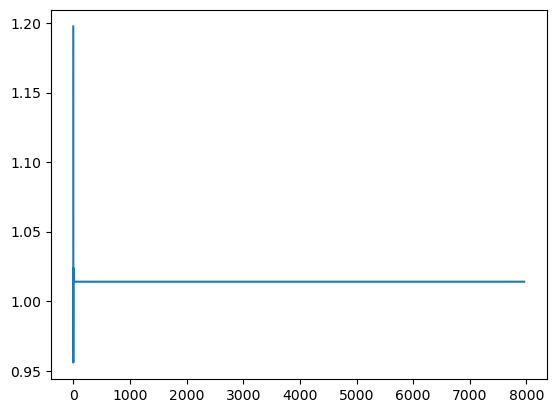

In [16]:
plt.plot(Y_pred_grad[:,0])

(0.0, 500.0)

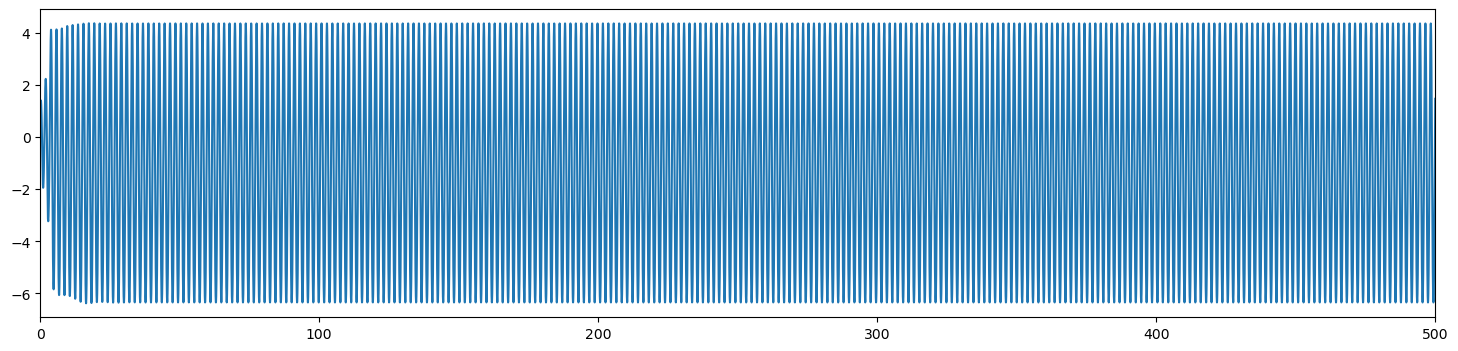

In [12]:
plt.figure(figsize=(18,4))
plt.plot(t_bar[::10],y_bar[::10,0])
plt.xlim([0,500])

(117.5, 118.5)

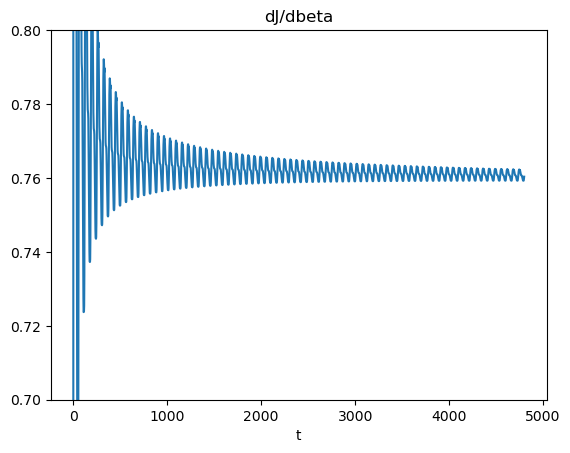

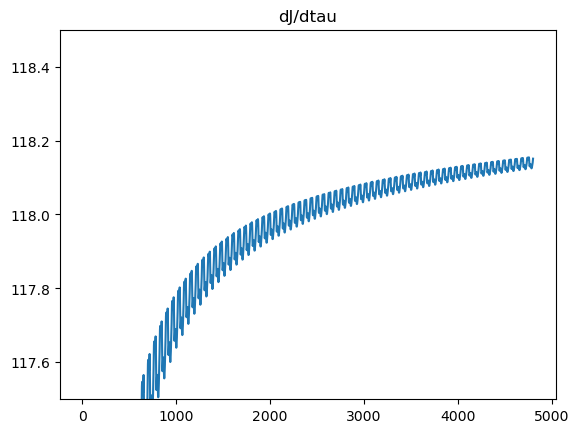

In [69]:
plt.figure()
plt.plot(t_bar[1::2000],1/t_bar[1::2000]*adj[1::2000,-2])
plt.xlabel("t")
plt.title("dJ/dbeta")
#plt.xlim([4000,4200])
plt.ylim([0.755,0.765])
plt.figure()
plt.plot(t_bar[1::2000],1/t_bar[1::2000]*adj[1::2000,-1])
plt.title("dJ/dtau")
#plt.xlim([4000,4200])
plt.ylim([117.5,118.5])

In [3]:
a = None
b = None
if a is not None and b is not None:
    if a is not None:
        print(a)
    elif b is not None:
        print(b)
else:
    print("None")

None


In [ ]:
shift_idx = 0
shift_len = 10
window_len = 800
window_idx = int(window_len/data_dt) 
n_bins = int((t_sim_len-4-window_len)/shift_len)
J = np.zeros(n_bins)
for i in range(n_bins):
    print(t_bar[shift_idx], t_bar[shift_idx+window_idx])
    J[i] = 1/4*np.mean(np.sum(y_bar[shift_idx:shift_idx+window_len,0:2*my_rijke.N_g]**2, axis = 1))
    shift_idx = int(shift_len*(i+1)/data_dt)
    print(J[i])
#plt.figure(figsize=(18,3))
plt.plot(J)

In [ ]:
for j in range(1):
    plt.figure(figsize = (20,3))
    plt.plot(t_bar[::upsample],y_bar[::upsample,j])
    #plt.xlim([0,20])

#for j in range(3):
#    plt.figure(figsize = (10,3))
#    plt.plot(t_bar,y_bar_beta_left[:,j])
#    plt.xlim([0,20])
#
#for j in range(3):
#    plt.figure(figsize = (10,3))
#    plt.plot(t_bar,y_bar_beta_right[:,j])
#    plt.xlim([0,20])

In [ ]:
## Taylor test
epsilon_list = [1,5e-1,1e-1,5e-2,1e-2,5e-3,1e-3,5e-4,1e-4,5e-5,1e-5,5e-6,1e-6,5e-7,1e-7]
J_0 = 1/4*np.mean(np.sum(Y_pred_grad[:N,:]**2, axis = 1))
taylor = np.zeros((len(epsilon_list),my_ESN.N_param_dim))
for epsilon_idx, epsilon in enumerate(epsilon_list):
    for i in range(my_ESN.N_param_dim):
        P_right = P_grad.copy()
        P_right[:,i] += epsilon
        X_right, Y_right =  my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_right)
        J_1 = 1/4*np.mean(np.sum(Y_right**2, axis = 1))
        taylor[epsilon_idx, i] = (J_1-J_0-epsilon*dJ_dp_adj_esn[i])/epsilon
        print("J_1-J_0:", J_1-J_0, "J_1-J_0-epsilon*dJ_dp_adj_esn",J_1-J_0-epsilon*dJ_dp_adj_esn[i])

plt.plot(epsilon_list,np.abs(taylor[:,0]),'o-')
plt.xlabel("log10(epsilon)")
plt.ylabel("|log10(J1-J0-epsilon*dJ/dp)|/epsilon")
plt.xscale("log")
plt.yscale("log")
plt.title("Taylor test")
plt.show()

In [ ]:
import pickle
def unpickle_file(file_name):
    file = open(file_name, 'rb')
    grad = pickle.load(file)
    dJ_dp = grad["dJ_dbeta"].copy()
    beta = grad["beta"].copy()
    file.close()
    return dJ_dp, beta

def pickle_file(file_name, dJ_dp, beta):
    file = open(file_name, 'wb')
    grad = {"beta": beta,
            "dJ_dbeta": dJ_dp,
            }
    pickle.dump(grad, file)
    file.close()
    return

# open a file, where you ant to store the data
#file = open('grad_true.pickle', 'rb')

# dump information to that file
#grad = {"beta": my_beta_list,
#        "dJ_dbeta": dJ_dp_num_esn,
#}
#pickle.dump(grad, file)

#grad_esn = pickle.load(file)
#dJ_dp_num_esn = grad_esn["dJ_dbeta"].copy()
#beta_esn = grad_esn["beta"].copy()
#
## close the file
#file.close()

#dJ_dp_num_true, my_beta_list = unpickle_file('grad_true.pickle')
#dJ_dp_num_esn, _ = unpickle_file('grad_esn_noisy_0_1.pickle')

pickle_file('grad_num_true_quasi.pickle', dJ_dp_num_true, my_beta_list)

In [ ]:
p_list_np = np.array(p_list)
my_beta_train_idx = (p_list_np[train_idx_list]-my_beta_list[0])/0.1
my_beta_train_idx = my_beta_train_idx.astype(int)
my_beta_val_idx = (p_list_np[val_idx_list]-my_beta_list[0])/0.1
my_beta_val_idx = my_beta_val_idx.astype(int)

In [ ]:
diff

In [ ]:
dJ_dp_num_true

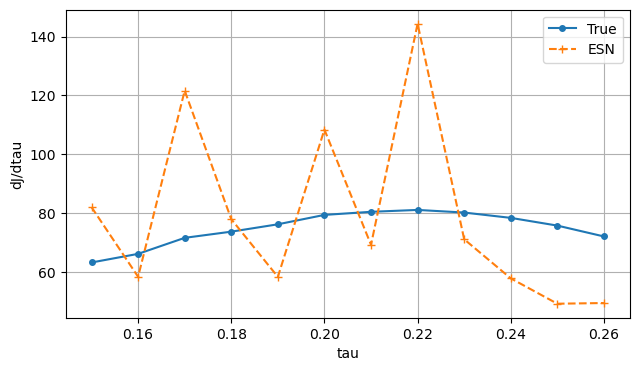

In [21]:
#diff = dJ_dp_num_true-dJ_dp_num_esn
#rel_err = 100*np.abs(dJ_dp_num_true-dJ_dp_num_esn)/np.abs(dJ_dp_num_true)
#print(diff)
#print(rel_err)
plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
plt.plot(my_p_list,dJ_dp_num_true,linestyle = '-',marker = 'o', markersize = 4)
plt.plot(my_p_list,dJ_dp_num_esn,linestyle = '--',marker = '+')
#plt.plot(my_beta_list[my_beta_train_idx], dJ_dp_num_true[my_beta_train_idx], color = 'red', linestyle = 'None', marker = 'o', markersize = 10, markerfacecolor = 'None')
#plt.plot(my_beta_list[my_beta_val_idx], dJ_dp_num_true[my_beta_val_idx], color = 'green', linestyle = 'None', marker = 's', markersize = 10, markerfacecolor = 'None')
plt.xlabel("tau")
plt.ylabel("dJ/dtau")
plt.legend(["True","ESN","Train","Val"])
#plt.ylim([-50,25])
plt.grid()

#plt.subplot(1,2,2)
#plt.plot(my_beta_list,rel_err,linestyle = '-',marker = 'o')
#plt.plot(my_beta_list[my_beta_train_idx], rel_err[my_beta_train_idx], color = 'red', linestyle = 'None', marker = 'o', markersize = 10, markerfacecolor = 'None')
#plt.plot(my_beta_list[my_beta_val_idx], rel_err[my_beta_val_idx], color = 'green', linestyle = 'None', marker = 's', markersize = 10, markerfacecolor = 'None')
#plt.xlabel("beta")
#plt.ylabel("Relative error")
#plt.legend(["Error","Train","Val"])
##plt.ylim([-0.5,23])
#plt.grid()

In [ ]:
#eta = y_sim[:, 0 : my_rijke.N_g]
#u_f_sim = Rijke.toVelocity(my_rijke.N_g, eta, np.array([my_rijke.x_f]))
#c_idx = np.where(np.abs(-1-u_f_sim) < 1e-2)[0]
#plt.figure(figsize=(12,4))
#plt.plot(t_sim,u_f_sim)
#plt.plot(t_sim[c_idx],u_f_sim[c_idx],'ro')
#plt.xlabel("t")
#plt.ylabel("u_f")
#plt.show()

In [ ]:
# OBJECTIVE SQUARED L2 OF RESERVOIR STATES
# calculate gradient for a timeseries, direct method
# time averaged objective
#N = X_pred_train.shape[0]
N = len(U_grad)
q = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
q_prev = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
dJ_dp = np.zeros(my_ESN.N_param_dim)
for i in np.arange(1,N):
    q = my_ESN.drdp(X_pred_grad[i,:]).toarray()+np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray(),q_prev)
    q_prev = q   
    dJ_dp += np.dot(2*X_pred_grad[i,:],q)
dJ_dp = (1/N)*dJ_dp

# calculate gradient for a timeseries, adjoint method
# time averaged objective
v_prev = (1/N)*2*X_pred_grad[N-1,:]
dJ_dp_adj = np.zeros(my_ESN.N_param_dim)
for i in np.arange(N-1,0,-1):
    dJ_dp_adj += np.dot(my_ESN.drdp(X_pred_grad[i,:]).toarray().T,v_prev)
    v = np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray().T,v_prev)+ (1/N)*2*X_pred_grad[i-1,:].T
    v_prev = v

# calculate gradient for a timeseries, numerical method
# time averaged objective 
h = 1e-5
dJ_dp_num = np.zeros((my_ESN.N_param_dim))
for i in range(my_ESN.N_param_dim):
    P_left = P_grad.copy()
    P_left[:,i] -= h
    P_right = P_grad.copy()
    P_right[:,i] += h
    X_left, _ = my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_left)
    X_right, _ =  my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_right)
    J_left = np.mean(np.sum(X_left**2, axis = 1))
    J_right = np.mean(np.sum(X_right**2, axis = 1))
    dJ_dp_num[i] = (J_right-J_left)/(2*h)
    
print(dJ_dp)
print(dJ_dp_adj)
print(dJ_dp_num)

# Taylor test
epsilon_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
J_0 = np.mean(np.sum(X_pred_grad[:N,:]**2, axis = 1))
taylor = np.zeros((len(epsilon_list),my_ESN.N_param_dim))
for epsilon_idx, epsilon in enumerate(epsilon_list):
    for i in range(my_ESN.N_param_dim):
        P_right = P_grad.copy()
        P_right[:,i] += epsilon
        X_right, _ =  my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_right)
        J_1 = np.mean(np.sum(X_right**2, axis = 1))
        taylor[epsilon_idx, i] = J_1-J_0-epsilon*dJ_dp_adj[i]
        print("J_1-J_0:", J_1-J_0, "J_1-J_0/epsilon",(J_1-J_0)/epsilon)

plt.plot(epsilon_list,np.abs(taylor[:,0]),'o-')
plt.xlabel("log10(epsilon)")
plt.ylabel("|log10(J1-J0-epsilon*dJ/dp)|")
plt.xscale("log")
plt.yscale("log")
plt.title("Taylor test")
plt.show()

In [ ]:
# OBJECTIVE SQUARED L2 OF OUTPUT STATES (ACOUSTIC ENERGY)
# calculate gradient for a timeseries, direct method
# time averaged objective
##N = X_pred_train.shape[0]
N = len(U_grad)
q = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
q_prev = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
dJ_dp = np.zeros(my_ESN.N_param_dim)
for i in np.arange(1,N):
    q = my_ESN.drdp(X_pred_grad[i,:]).toarray()+np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray(),q_prev)
    q_prev = q 
    X_pred_aug = np.hstack((X_pred_grad[i,:], my_ESN.b_out))
    dJ_dr = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    #dJ_dr2 = (1/N)*2*np.einsum("r, rb, bn -> n", X_pred_aug,my_ESN.W_out,my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    dJ_dp += np.dot(dJ_dr,q)

# calculate gradient for a timeseries, adjoint method
# time averaged objective
X_pred_aug = np.hstack((X_pred_grad[N-1,:], my_ESN.b_out))
v_prev = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T).T
dJ_dp_adj = np.zeros(my_ESN.N_param_dim)
for i in np.arange(N-1,0,-1):
    dJ_dp_adj += np.dot(my_ESN.drdp(X_pred_grad[i,:]).toarray().T,v_prev)
    X_pred_aug = np.hstack((X_pred_grad[i-1,:], my_ESN.b_out))
    dJ_dr = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T).T
    v = np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray().T,v_prev)+dJ_dr 
    v_prev = v

# calculate gradient for a timeseries, numerical method
# time averaged objective 
h = 1e-5
dJ_dp_num = np.zeros((my_ESN.N_param_dim))
for i in range(my_ESN.N_param_dim):
    P_left = P_grad.copy()
    P_left[:,i] -= h
    P_right = P_grad.copy()
    P_right[:,i] += h
    X_left, Y_left = my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_left)
    X_right, Y_right =  my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_right)
    J_left = 1/4*np.mean(np.sum(Y_left**2, axis = 1))
    J_right = 1/4*np.mean(np.sum(Y_right**2, axis = 1))
    dJ_dp_num[i] = (J_right-J_left)/(2*h)
    
#print(dJ_dp)
#print(dJ_dp_adj)
print(dJ_dp_num)

# Taylor test
epsilon_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
J_0 = 1/4*np.mean(np.sum(Y_pred_grad_[:N,:]**2, axis = 1))
taylor = np.zeros((len(epsilon_list),my_ESN.N_param_dim))
for epsilon_idx, epsilon in enumerate(epsilon_list):
    for i in range(my_ESN.N_param_dim):
        P_right = P_grad.copy()
        P_right[:,i] += epsilon
        X_right, Y_right =  my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_right)
        J_1 = 1/4*np.mean(np.sum(Y_right**2, axis = 1))
        taylor[epsilon_idx, i] = J_1-J_0-epsilon*dJ_dp_num[i]
        print("J_1-J_0:", J_1-J_0, "J_1-J_0/epsilon",(J_1-J_0)/epsilon)

plt.plot(epsilon_list,np.abs(taylor[:,0]),'o-')
plt.xlabel("log10(epsilon)")
plt.ylabel("|log10(J1-J0-epsilon*dJ/dp)|")
plt.xscale("log")
plt.yscale("log")
plt.title("Taylor test")
plt.show()

In [ ]:
#print("J(beta),ESN:",J_0)
#print("J(beta-h),ESN:",J_left)
#print("J(beta+h),ESN:",J_right)
#print("J(beta+h)-J(beta-h),ESN:",J_right-J_left)

In [ ]:
#print("J(beta),true:",J_beta)
#print("J(beta-h),true:",J_beta_left)
#print("J(beta+h),true:",J_beta_right)
#print("J(beta+h)-J(beta-h),true:",J_beta_right-J_beta_left)

In [ ]:
#np.mean(np.sum((y_bar[::upsample,0:2*my_rijke.N_g]-Y_pred_grad_)**2,axis=1))

In [ ]:
#for j in range(10):
#    plt.figure(figsize=(12,4))
#    plt.plot(t_bar,y_bar[:,j])
#    plt.plot(t_grad,Y_pred_grad_[:,j],'--')
#    plt.title(f"Mode {j}, beta")
#    plt.legend(["true","ESN"])
#
#    plt.figure(figsize=(12,4))
#    plt.plot(t_bar,y_bar_beta_left[:,j])
#    plt.plot(t_grad,Y_left[:,j],'--')
#    plt.title(f"Mode {j}, beta-h")
#    plt.legend(["true","ESN"])
#
#    plt.figure(figsize=(12,4))
#    plt.plot(t_bar,y_bar_beta_right[:,j])
#    plt.plot(t_grad,Y_right[:,j],'--')
#    plt.title(f"Mode {j}, beta+h")
#    plt.legend(["true","ESN"])

In [ ]:
#true_grad = np.array([3.4501,4.1069,4.7970,5.1688,5.4898,5.8237])
#esn_grad = np.array([3.2244,4.0068,4.8323,5.3201,5.6128,5.4578])
#100*np.abs(true_grad-esn_grad)/np.abs(true_grad)